In [13]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import inspect
import re
import os
pd.set_option('display.max_columns', None)
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import sqlite3 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier

In [7]:
db_path = os.path.join('..', 'data', 'database_credito.db')

try:
    conn = sqlite3.connect(db_path)
    print("Conectado a la base de datos con éxito")
except sqlite3.OperationalError as e:
    print(f"Error al abrir la base de datos: {e}")


Conectado a la base de datos con éxito


In [8]:

data_modelar = pd.read_sql('SELECT * FROM Datos_train_procesados', conn)
conn.close()

In [9]:
data_modelar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69511 entries, 0 to 69510
Data columns (total 31 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Edad                              69511 non-null  int64  
 1   Ingreso_Anual                     69511 non-null  float64
 2   Salario_Mensual_En_Mano           69511 non-null  float64
 3   Numero_Cuentas_Bancarias          69511 non-null  int64  
 4   Numero_Tarjetas_Credito           69511 non-null  int64  
 5   Tasa_Interes                      69511 non-null  int64  
 6   Retraso_Promedio_Pagos            69511 non-null  int64  
 7   Numero_Promedio_Pagos_Retrasados  69511 non-null  float64
 8   Cambio_Limite_Credito             69511 non-null  float64
 9   Numero_Consultas_Credito          69511 non-null  float64
 10  Deuda_Pendiente                   69511 non-null  float64
 11  Ratio_Uso_Credito                 69511 non-null  float64
 12  Anti

In [11]:


# Supongamos que 'Puntaje_Credito' es tu variable objetivo
X = data_modelar.drop(columns=['Puntaje_Credito'])  # Variables predictoras
y = data_modelar['Puntaje_Credito']  # Variable objetivo

# Realizar la división en 80% entrenamiento y 20% prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear un pipeline con un clasificador genérico y StandardScaler
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Escalador estándar
    ('classifier', LogisticRegression())  # Clasificador genérico, será sustituido por los modelos en el GridSearch
])

# Definir los modelos a probar con StandardScaler
param_grid = [
    {'classifier': [LogisticRegression()]},
    {'classifier': [SVC()]},
    {'classifier': [RandomForestClassifier()]},
    {'classifier': [GradientBoostingClassifier()]},
    {'classifier': [AdaBoostClassifier()]},
    {'classifier': [KNeighborsClassifier()]},
    {'classifier': [GaussianNB()]},
    {'classifier': [DecisionTreeClassifier()]},
    {'classifier': [MLPClassifier()]},
    {'classifier': [LinearDiscriminantAnalysis()]},
    {'classifier': [QuadraticDiscriminantAnalysis()]},
    {'classifier': [XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')]}
]

# Crear el objeto GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)

# Ajustar el GridSearch a los datos (usa tu conjunto de datos en lugar de X_train e y_train)
grid_search.fit(X_train, y_train)

# Mostrar los resultados de precisión de todos los modelos
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']

print("Resultados de precisión (accuracy) para cada modelo con StandardScaler:")
for mean, std, param in zip(means, stds, params):
    print(f"Classifier: {param['classifier'].__class__.__name__}: {mean:.2%} (+/- {std:.2%})")

# Mejor modelo encontrado
best_model = grid_search.best_estimator_
print("\nMejor modelo:", best_model)


Resultados de precisión (accuracy) para cada modelo con StandardScaler:
Classifier: LogisticRegression: 65.25% (+/- 0.41%)
Classifier: SVC: 70.52% (+/- 0.25%)
Classifier: RandomForestClassifier: 79.01% (+/- 0.64%)
Classifier: GradientBoostingClassifier: 71.68% (+/- 0.42%)
Classifier: AdaBoostClassifier: 66.88% (+/- 0.54%)
Classifier: KNeighborsClassifier: 71.05% (+/- 0.44%)
Classifier: GaussianNB: 59.74% (+/- 0.38%)
Classifier: DecisionTreeClassifier: 69.75% (+/- 0.24%)
Classifier: MLPClassifier: 69.53% (+/- 0.71%)
Classifier: LinearDiscriminantAnalysis: 65.16% (+/- 0.37%)
Classifier: QuadraticDiscriminantAnalysis: 65.23% (+/- 0.35%)
Classifier: XGBClassifier: 75.81% (+/- 0.46%)

Mejor modelo: Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', RandomForestClassifier())])


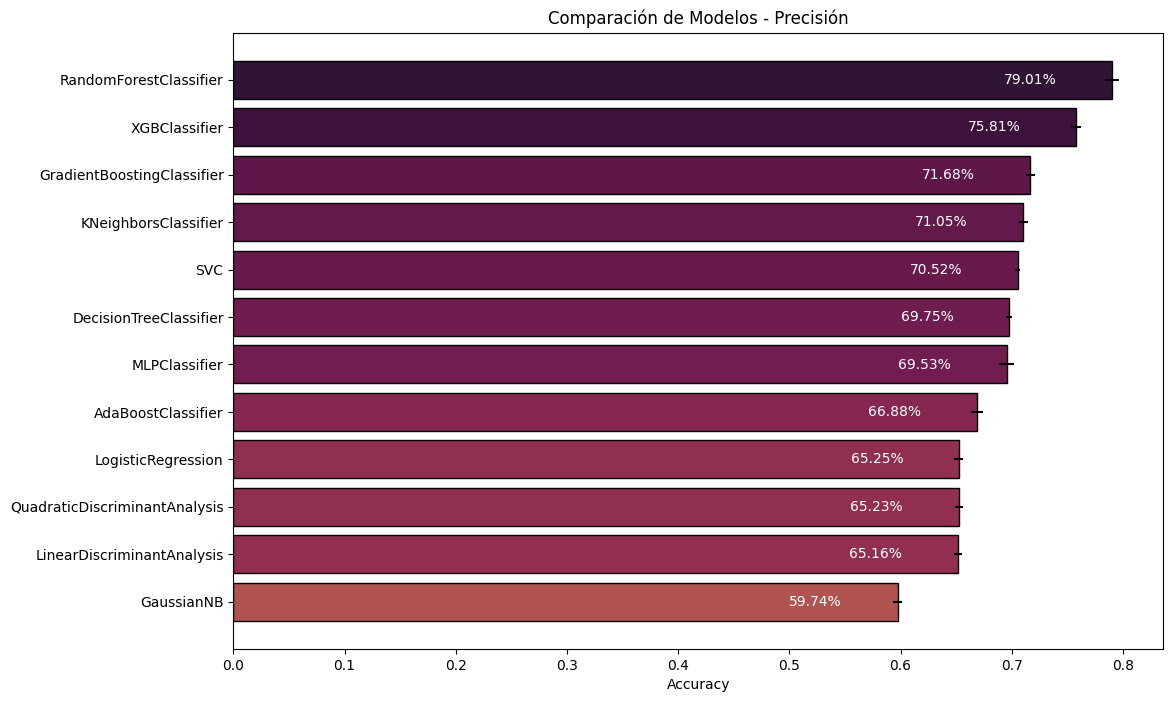

In [28]:
def plot_grid_search_results_with_values(grid_search):
    # Extraer los nombres de los clasificadores, sus medias y desviaciones estándar
    classifiers = [param['classifier'].__class__.__name__ for param in grid_search.cv_results_['params']]
    means = grid_search.cv_results_['mean_test_score']
    stds = grid_search.cv_results_['std_test_score']
    
    # Ordenar los resultados por la precisión media
    sorted_indices = means.argsort()[::-1]
    classifiers = [classifiers[i] for i in sorted_indices]
    means = means[sorted_indices]
    stds = stds[sorted_indices]

    # Configuración del colormap
    cmap = plt.get_cmap('twilight_shifted')  # Usando una paleta de colores variada
    colors = cmap(means / max(means))  # Generando los colores basados en los valores de precisión

    # Crear el gráfico de barras
    plt.figure(figsize=(12, 8))
    bars = plt.barh(classifiers, means, xerr=stds, color=colors, edgecolor='black')
    plt.xlabel('Accuracy')
    plt.title('Comparación de Modelos - Precisión')
    plt.gca().invert_yaxis()  # Invertir el eje Y para que el modelo con mayor precisión esté en la parte superior

    # Añadir los valores de precisión dentro de las barras
    for bar, mean in zip(bars, means):
        plt.text(bar.get_width() - 0.05, bar.get_y() + bar.get_height()/2, f'{mean:.2%}', 
                 va='center', ha='right', fontsize=10, color='white' if mean / max(means) > 0.5 else 'black')

    plt.show()

# Llamar a la función para graficar los resultados
plot_grid_search_results_with_values(grid_search)


Con ello podemos ver que el mejor modelo para predecir nuestros valores sera el random forest classifier